# Find most important feature in a model predictions using influence functions

Pang Wei Koh and Percy Lian show in their ["Understanding Black-box Predictions via Influence Functions"](https://arxiv.org/pdf/1703.04730.pdf) (ICML 2017) that influence functions can be used to approximate the learning effect of training data onto the predictions.
An extension of this is the ability to approximate the effect of a given perturbation on a training point.

The original authors demonstrate how this also enables engineering adversarial training attack. The attack consists in finding the most influential training input for a given test point prediction. Then approximating the perturbation that has the maximally negative learning effect on learning the test point.

The author suggest the possibility of using influence functions to approximate the effect of perturbing the training point has a way to analyse the training effects of features.


We use the original code from the offical authors repository for the model classes and various utilities. We use the Kaggle [Titanic dataset](https://www.kaggle.com/c/titanic/data) to experiment on the idea of using influence functions to approximate the effect of features on learning in a blackbox model.

**Plan**

1. Preprocess data
2. Train model (logistic regression)
3. Test model
4. Engineer adversarial training training data to degrade the performance of the model.
5. Analyse the noise added to the feature as a characterization of the influence of feature in learning for the model.





3. For each correctly labelled test point:
       Find most their influential training points
       Approximate the perturbation effect on each point
       
+ For each feature:
	For each train point:
	    Get influence on loss of perturbation of given training point on given feature
+ Get stats:
	+ Average by feature of their influence on z-test
	+(other stats)
    

In [1]:
N_BEST_PREDS = 50
N_INFLUENT_TRAIN = 50

### Preparation of the dataset

In [2]:
import pandas as pd
import numpy as np

fpath_titanic = "/home/eolus/Desktop/Dauphine/datamining/projets/blackBox/data/train.csv"
train_df = pd.read_csv(fpath_titanic)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def extract_prefix(name):
    import re
    try:
        return re.search('(Mr\.)|(Mrs\.)|(Miss\.)', name).group()
    except:
        return ""


train_df['Prefix'] = train_df.Name.apply(extract_prefix)

for cat_col in ['Sex', 'Embarked', 'Prefix' ]:
    train_df[cat_col] = pd.factorize(train_df[cat_col])[0]
    
train_df['Age'].fillna(train_df.Age.mean(), inplace=True)    

In [4]:
features = ['Prefix', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

X = np.array(train_df[features])
y = np.array((train_df.Survived > 0).astype('int32'))

In [5]:
# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Need to train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
# Create dataset objects
import sys
sys.path.append("..")

#from influence indataset as dataset
from influence.dataset import DataSet
import numpy as np
lr_train = DataSet(X_train, np.array(y_train, dtype=int))
lr_test = DataSet(X_test, np.array(y_test, dtype=int))
lr_validation = None

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

### Train model of reference

In [7]:
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS

num_classes = 2
input_dim = len(features)

weight_decay = 0.01
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000

tf.reset_default_graph()

tf_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='tmp',
    log_dir='tmp',
    model_name='titanic')

tf_model.train()


Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Total number of parameters: 8
Using normal model
LBFGS training took [10] iter.
After training with LBFGS: 


In [8]:
# Retrieve test predictions and reference labels
preds_p = tf_model.get_preds().tolist()
preds = [1 if el[0] < 0.5 else 0 for el in preds_p]
ref = tf_model.data_sets.test.labels

# True/False - Positives/Negatives    
true_pos = [(i, p) for i, p in enumerate(preds_p) if p[0] < p[1] and ref[i] == 1]
true_neg = [(i, p) for i, p in enumerate(preds_p) if p[0] > p[1] and ref[i] == 0]
false_pos = [(i, p) for i, p in enumerate(preds_p) if p[0] < p[1] and ref[i] == 0]
false_neg = [(i, p) for i, p in enumerate(preds_p) if p[0] > p[1] and ref[i] == 1]

# Confusion matrix data
print("true_positives:", len(true_pos))
print("true_negatives:", len(true_neg))
print("false_positives", len(false_pos))
print("false_negatives", len(false_neg))

# Sort true_positives and true_negatives by how confident the model is
true_pos_top = sorted(true_pos, key=lambda x : x[1][0], reverse=False)
true_neg_top = sorted(true_neg, key=lambda x : x[1][0], reverse=True)

# Sample down (top 10)
true_pos_top = true_pos_top[:N_BEST_PREDS]
true_neg_top = true_neg_top[:N_BEST_PREDS]

true_positives: 100
true_negatives: 137
false_positives 38
false_negatives 20


## Find most influential train points

For each true positive / true negative prediction for which the model predicted with high confidence, we approximate which train points are most responsible for the prediction.

In [9]:
def get_top_train_influence(idx, n_train_points=N_INFLUENT_TRAIN):
    """
    Approximate most influential train points for a test point
    idx : index of test point
    """
    num_train = len(tf_model.data_sets.train.labels)
    influences = tf_model.get_influence_on_test_loss(
        [idx], 
        np.arange(len(tf_model.data_sets.train.labels)),
        force_refresh=True) * num_train
    influences_sorted = sorted(enumerate(influences),
                               key=lambda x:x[1],
                               reverse=True)
    influences_sorted = influences_sorted[:n_train_points]
    return influences_sorted

In [10]:
# Get test points indices
true_pos_top_idx = [top_pos[0] for top_pos in true_pos_top]
true_neg_top_idx = [top_neg[0] for top_neg in true_neg_top]

# Approximate most influential train points for each test point
influence_train_true_pos = [get_top_train_influence(idx) for idx in true_pos_top_idx]
influence_train_true_neg = [get_top_train_influence(idx) for idx in true_neg_top_idx]

         Current function value: -0.026063
         Iterations: 4
         Function evaluations: 89
         Gradient evaluations: 82
         Hessian evaluations: 19
Optimization terminated successfully.
         Current function value: -0.030229
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 12
         Hessian evaluations: 21
Optimization terminated successfully.
         Current function value: -0.064258
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 12
         Hessian evaluations: 22
         Current function value: -0.030219
         Iterations: 5
         Function evaluations: 134
         Gradient evaluations: 126
         Hessian evaluations: 26
         Current function value: -0.070613
         Iterations: 5
         Function evaluations: 74
         Gradient evaluations: 69
         Hessian evaluations: 28
         Current function value: -0.024056
         Iterations: 4
         Function evalu

## Find most important features for each prediction using the influence perturbation function

For each influential train point, we get the gradient of influence wrt to input to estimate the perturbation that optimally effect learning performance.

In [11]:
def get_top_pert_influence(train_indices, test_idx):
    """
    Approximate most grad of influence wrt training points in order to
    find most important feature.
    """
    influences_grad = tf_model.get_grad_of_influence_wrt_input(
        train_indices, [test_idx], force_refresh=False)
    return influences_grad

In [12]:
true_pos_influences_grad = [] 
for test_idx, train_top in zip(true_pos_top_idx, influence_train_true_pos):
    train_indices = [r[0] for r in train_top]
    top_pert_influence = get_top_pert_influence(train_indices, test_idx)
    true_pos_influences_grad.append(top_pert_influence)

true_neg_influences_grad = [] 
for test_idx, train_top in zip(true_neg_top_idx, influence_train_true_neg):
    train_indices = [r[0] for r in train_top]
    top_pert_influence = get_top_pert_influence(train_indices, test_idx)
    true_neg_influences_grad.append(top_pert_influence)

### Analysis

We now observe the gradient of the influence wrt to the input features.
The influence of the perturbations of the training points on the loss tells us about which features are important for the model predictions.

We retrieve the perturbations of the inputs that maximally effect the loss on the test points.
We analyse the perturbation to understand which feature drive the model predictions.

In [13]:
def influence_grad_dict(features, influences_grad):
    grad_features_values = { f : [] for f in features }
    for test_data in influences_grad:
        for train_data in test_data:
            for i, grad in enumerate(train_data):
                grad_features_values[features[i]].append(grad)
    return grad_features_values


def feature_stats(features, influences_grad):
    import numpy as np
    grad_features_values= influence_grad_dict(features, influences_grad)          
    tups = [
        (f_name, np.var(grad_values), np.average(grad_values))
        for f_name, grad_values in grad_features_values.items() ]

    tups = sorted(tups, key=lambda x: abs(x[2]), reverse=True)

    for feature, var, avg in tups:
        print(feature, "\n\tAVG:", avg, "\n\tVAR:", var)

In [14]:
print("TRUE POSITIVES INFLUENTIAL FEATURES")
feature_stats(features, true_pos_influences_grad)

print("\n\nTRUE NEGATIVE INFLUENTIAL FEATURES")
feature_stats(features, true_neg_influences_grad)

TRUE POSITIVES INFLUENTIAL FEATURES
Fare 
	AVG: -0.05108401117101312 
	VAR: 0.20082200068416445
Parch 
	AVG: 0.01907227040939033 
	VAR: 0.11248297806351902
Prefix 
	AVG: -0.013998375711590051 
	VAR: 0.10654844513014988
SibSp 
	AVG: 0.010458289708569646 
	VAR: 0.07671645075237837
Pclass 
	AVG: -0.008284880821406842 
	VAR: 0.1041413355863596
Embarked 
	AVG: 0.006957733903452754 
	VAR: 0.11202453165464474
Sex 
	AVG: -0.0011869948536157608 
	VAR: 0.36937706006165344
Age 
	AVG: 0.00039961614534258843 
	VAR: 0.12821811774223948


TRUE NEGATIVE INFLUENTIAL FEATURES
Sex 
	AVG: 0.12517564322650432 
	VAR: 0.15088478361163768
Pclass 
	AVG: -0.09231183665394783 
	VAR: 0.11792909393332646
Embarked 
	AVG: 0.03802657387107611 
	VAR: 0.08102229123563227
Age 
	AVG: -0.033213538988679646 
	VAR: 0.16679372031011244
Parch 
	AVG: 0.024273867635428905 
	VAR: 0.10391033918702856
Prefix 
	AVG: 0.019402976520359515 
	VAR: 0.0643657284403195
SibSp 
	AVG: -0.011975104065239429 
	VAR: 0.08625101811778878
Fare 
	A

### Gradient of influence wrt input: Value distribution

In [15]:
def feature_vis(feature_name, grad_values):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    ns.set_style('whitegrid')
    print(feature_name)
    sns.kdeplot(data=np.array(grad_values), bw=0.5)
    plt.show()

true positives
***********************
Prefix
Pclass
Sex
Age
SibSp
Parch
Fare
Embarked


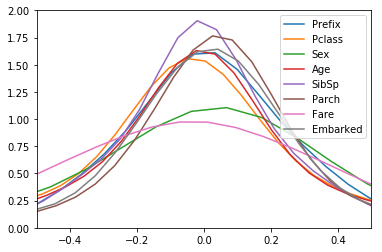

true negatives
***********************
Prefix
Pclass
Sex
Age
SibSp
Parch
Fare
Embarked


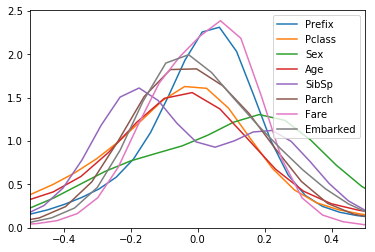

In [21]:
grad_dict_true_pos = influence_grad_dict(features, true_pos_influences_grad)
grad_dict_true_neg = influence_grad_dict(features, true_neg_influences_grad)

for confusion_class, grad_dict in [
    ("true positives", grad_dict_true_pos),
    ("true negatives", grad_dict_true_neg)
]:
    print(confusion_class)
    print('***********************')
    try:
        for feature_name, values in grad_dict.items():
            #print(feature_name)
            #print(values)
            
            import matplotlib.pyplot as plt
            import seaborn as sns
            print(feature_name)
            plt.xlim(-0.5, 0.5)
            sns.kdeplot(data=np.array(values), bw=0.4, label=feature_name)

        plt.show()
            
            #feature_vis(feature_name, values)
    except Exception as e:
        print(e)
        print(values)

### Benchmark feature importance

+ Mutual information
+ Recursive feature elimination (using logit)

In [17]:
from sklearn.feature_selection import mutual_info_classif
mi_scores = sorted(zip(features, mutual_info_classif(X, y)), key=lambda x : x[1], reverse=True)
print("Mutual information scores:")
print("----------------------------")
for mi in mi_scores:
    print("{} {}".format(round(mi[1], 3), mi[0]))

Mutual information scores:
----------------------------
0.165 Sex
0.156 Prefix
0.143 Fare
0.074 Pclass
0.032 Age
0.022 Embarked
0.014 SibSp
0.0 Parch


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

estimator = LogisticRegression()
selector = RFECV(estimator, step=3, cv=3)
selector = selector.fit(X_train, y_train)


features_importance = zip(features, selector.estimator_.coef_[0])
sorted_logit_coefs = sorted(features_importance, key=lambda x : abs(x[1]), reverse=True)
print("Logit regression coefficients, test:{}".format(round(selector.score(X_test, y_test),  2)))
print("----------------------------------------------")
for el in sorted_logit_coefs:
    print(round(abs(el[1]), 2), el[0])

Logit regression coefficients, test:0.82
----------------------------------------------
1.0 Sex
0.72 Pclass
0.39 Prefix
0.38 SibSp
0.29 Age
0.19 Fare
0.16 Embarked
0.1 Parch
